In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import plotly.graph_objs as go
%matplotlib inline
from random import sample
import seaborn as sns
import datetime as dt
from pandas_datareader import data as pdr
from dataclasses import dataclass

In [4]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [5]:
def weekly_data(index):
    index_ffill = index.resample('d').asfreq().ffill() 
    index_fri = index_ffill[index_ffill.index.dayofweek==4]
    return index_fri

In [6]:
def EWMA(df, n):
    EWMA = pd.Series(df["Adj Close"].ewm(span=n).mean(),name = "EWMA_" + str(n))
    return EWMA

def EWMV(df, n):
    EWMV = pd.Series(df.ewm(span=n).mean(),name = "EWMV_" + str(n))
    return EWMV

def ATR(df,n):
    ATR = pd.concat([(df['High']-df['Low']),
           np.abs(df['High'] - df['Adj Close'].shift(1)),
           np.abs(df['Low']-df['Adj Close'].shift(1))],axis=1).max(axis=1).rolling(n).mean()
    return ATR

def DIV(df,N):
    alpha = 1.34
    k =(alpha-1)/(alpha+(N+1)/(N-1))
    c = np.log(df['Adj Close']/df['Open'])
    u = np.log(df['Adj Close']/df['Open'])
    o = np.log(df['Open']/df['Adj Close'].shift(1))
    d = np.log(df['Low']/df['Open'])
    V0 = ((o-o.rolling(N).mean())**2).rolling(N).sum()/(N-1)
    Vc = ((c-c.rolling(N).mean())**2).rolling(N).sum()/(N-1)
    Vrs = (u*(u-c)+d*(d-c)).rolling(N).mean()
    DIV = V0 + k*Vc +(1-k)*Vrs
    return DIV

In [7]:
def g_mean_f1(y_true,y_pred):
    c_m = confusion_matrix(y_true,y_pred)
    p_precision = c_m[0,0] / (c_m[0,0] + c_m[0,1])
    p_recall = c_m[0,0] / (c_m[0,0] + c_m[1,0])
    n_precision = c_m[1,1] / (c_m[1,1] + c_m[1,0])
    n_recall = c_m[1,1] / (c_m[1,1] + c_m[0,1])
    p_f1_score = 2*(p_precision * p_recall)/(p_precision+p_recall)
    n_f1_score = 2*(n_precision * n_recall)/(n_precision+n_recall)
    return (p_f1_score * n_f1_score)**0.5

### V2X

In [8]:
v2tx = pd.read_csv('v2tx.csv',index_col=[0])[::-1]
v2tx.index = pd.to_datetime(v2tx.index)
v2tx.rename(columns={'Price':'Adj Close'},inplace=True)
v2tx_w = weekly_data(v2tx)
v2tx_w

,Adj Close,Open,High,Low,Vol.,Change %,vix_return,EWMA_1,EWMA_2
Date,,,,,,,,,
2012-12-28,21.35,17.84,21.35,17.79,NaN,17.11%,0.000000,17.84,17.840000
2013-01-04,16.07,17.82,17.87,16.05,NaN,-8.38%,-0.284098,17.82,17.825000
2013-01-11,15.57,15.98,16.11,15.56,NaN,-3.41%,-0.031608,15.98,16.547692
2013-01-18,15.88,15.93,16.26,15.64,NaN,-0.19%,0.019714,15.93,16.130750
2013-01-25,14.91,15.35,15.40,14.61,NaN,-2.61%,-0.063028,15.35,15.608099
...,...,...,...,...,...,...,...,...,...
2022-10-28,24.89,26.33,26.61,24.69,NaN,-3.80%,-0.111648,26.33,27.159728
2022-11-04,22.91,23.57,23.69,22.34,NaN,-3.64%,-0.082893,23.57,24.766576
2022-11-11,20.78,21.59,21.85,20.77,NaN,-2.54%,-0.097583,21.59,22.648859


In [9]:
v2tx_w['vix_return'] = np.log(v2tx_w['Adj Close']/v2tx_w['Adj Close'].shift(1)).fillna(0)
v2tx_w['EWMA_1'] = EWMA(v2tx_w,1)
v2tx_w['EWMA_2'] = EWMA(v2tx_w,2)
v2tx_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 518 entries, 2012-12-28 to 2022-11-25
Freq: 7D
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Adj Close   518 non-null    float64
 1   Open        518 non-null    float64
 2   High        518 non-null    float64
 3   Low         518 non-null    float64
 4   Vol.        0 non-null      float64
 5   Change %    518 non-null    object 
 6   vix_return  518 non-null    float64
 7   EWMA_1      518 non-null    float64
 8   EWMA_2      518 non-null    float64
dtypes: float64(8), object(1)
memory usage: 40.5+ KB


### stock index

In [10]:
start = dt.date(2012, 12,28)
end = dt.date(2022, 11, 29)
ESTX=pdr.get_data_yahoo('^STOXX50E',start=start,end=end)
ESTX_w = weekly_data(ESTX)
ESTX_w

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-12-28,2664.370117,2626.409912,2660.889893,2626.850098,0.0,2626.850098
2013-01-04,2711.020020,2690.110107,2696.939941,2709.350098,0.0,2709.350098
2013-01-11,2719.989990,2702.719971,2712.780029,2717.790039,0.0,2717.790039
2013-01-18,2731.040039,2707.350098,2723.879883,2709.590088,0.0,2709.590088
2013-01-25,2748.129883,2716.090088,2721.500000,2744.179932,0.0,2744.179932
...,...,...,...,...,...,...
2022-10-28,3615.909912,3558.550049,3594.600098,3613.020020,29709100.0,3613.020020
2022-11-04,3711.209961,3601.919922,3601.919922,3688.330078,50017600.0,3688.330078
2022-11-11,3890.250000,3859.500000,3873.070068,3868.500000,38268800.0,3868.500000


In [11]:
ESTX_w['estx_return'] = np.log(ESTX_w['Adj Close']/ESTX_w['Adj Close'].shift(1)).fillna(0)
ESTX_w['EWMV_2'] = EWMV(ESTX_w['estx_return'],2)
ESTX_w['ATR_2'] = ATR(ESTX_w,2)
ESTX_w['ATR_4'] = ATR(ESTX_w,4)
ESTX_w['DIV_2'] = DIV(ESTX_w,2)
ESTX_w['DIV_4'] = DIV(ESTX_w,4)
ESTX_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 518 entries, 2012-12-28 to 2022-11-25
Freq: 7D
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   High         518 non-null    float64
 1   Low          518 non-null    float64
 2   Open         518 non-null    float64
 3   Close        518 non-null    float64
 4   Volume       518 non-null    float64
 5   Adj Close    518 non-null    float64
 6   estx_return  518 non-null    float64
 7   EWMV_2       518 non-null    float64
 8   ATR_2        517 non-null    float64
 9   ATR_4        515 non-null    float64
 10  DIV_2        515 non-null    float64
 11  DIV_4        511 non-null    float64
dtypes: float64(12)
memory usage: 52.6 KB


### USD/EUR

In [12]:
start = dt.date(2012, 12,28)
end = dt.date(2022, 11, 29)
eur = pdr.get_data_yahoo('EUR=X',start=start,end=end)
eur_w = weekly_data(eur)
eur_w['eur_return'] = np.log(eur_w['Adj Close']/eur_w['Adj Close'].shift(1)).fillna(0)
eur_w

,High,Low,Open,Close,Volume,Adj Close,eur_return
Date,,,,,,,
2012-12-28,0.75951,0.754300,0.75480,0.75470,0.0,0.75470,0.000000
2013-01-04,0.76920,0.765474,0.76740,0.76730,0.0,0.76730,0.016558
2013-01-11,0.75460,0.748385,0.75340,0.75340,0.0,0.75340,-0.018282
2013-01-18,0.75203,0.746400,0.74780,0.74780,0.0,0.74780,-0.007461
2013-01-25,0.74888,0.741889,0.74800,0.74798,0.0,0.74798,0.000241
...,...,...,...,...,...,...,...
2022-10-28,1.00690,1.000100,1.00323,1.00323,0.0,1.00323,-0.019133
2022-11-04,1.02580,1.006220,1.02568,1.02568,0.0,1.02568,0.022131
2022-11-11,0.98365,0.967270,0.98114,0.98114,0.0,0.98114,-0.044396


### Stock Index

In [21]:
start = dt.date(2012, 12,28)
end = dt.date(2022, 11, 29)
sp500=pdr.get_data_yahoo('^GSPC',start=start,end=end)
sp500_w = weekly_data(sp500)
sp500_w['sp500_return'] = np.log(sp500_w['Adj Close']/sp500_w['Adj Close'].shift(1)).fillna(0)
sp500_w

,High,Low,Open,Close,Volume,Adj Close,sp500_return
Date,,,,,,,
2012-12-28,1418.099976,1401.579956,1418.099976,1402.430054,2.426680e+09,1402.430054,0.000000
2013-01-04,1467.939941,1458.989990,1459.369995,1466.469971,3.424290e+09,1466.469971,0.044652
2013-01-11,1472.750000,1467.579956,1472.119995,1472.050049,3.340650e+09,1472.050049,0.003798
2013-01-18,1485.979980,1475.810059,1480.949951,1485.979980,3.795740e+09,1485.979980,0.009418
2013-01-25,1503.260010,1494.819946,1494.819946,1502.959961,3.476290e+09,1502.959961,0.011362
...,...,...,...,...,...,...,...
2022-10-28,3905.419922,3808.260010,3808.260010,3901.060059,4.459410e+09,3901.060059,0.038759
2022-11-04,3796.340088,3708.840088,3766.979980,3770.550049,5.400180e+09,3770.550049,-0.034027
2022-11-11,4001.479980,3944.820068,3963.719971,3992.929932,5.593310e+09,3992.929932,0.057304


### US VIX

In [22]:
start = dt.date(2012, 12,28)
end = dt.date(2022, 11, 29)
vix=pdr.get_data_yahoo('^VIX',start=start,end=end)
vix_w = weekly_data(vix)
vix_w['us_vix_return'] = np.log(vix_w['Adj Close']/vix_w['Adj Close'].shift(1)).fillna(0)
vix_w

,High,Low,Open,Close,Volume,Adj Close,us_vix_return
Date,,,,,,,
2012-12-28,23.230000,19.940001,20.320000,22.719999,0.0,22.719999,0.000000
2013-01-04,14.310000,13.640000,14.230000,13.830000,0.0,13.830000,-0.496405
2013-01-11,13.790000,13.220000,13.550000,13.360000,0.0,13.360000,-0.034575
2013-01-18,13.530000,12.290000,13.520000,12.460000,0.0,12.460000,-0.069742
2013-01-25,12.990000,12.500000,12.630000,12.890000,0.0,12.890000,0.033928
...,...,...,...,...,...,...,...
2022-10-28,27.590000,25.750000,27.430000,25.750000,0.0,25.750000,-0.142376
2022-11-04,25.709999,24.000000,25.629999,24.549999,0.0,24.549999,-0.047723
2022-11-11,23.910000,22.370001,23.889999,22.520000,0.0,22.520000,-0.086308


### bond yield

In [23]:
bond = pd.read_csv('bond.csv',index_col=[0])
bond.index = pd.to_datetime(bond.index)
bond_w = weekly_data(bond)
gm_bond = bond_w.iloc[:,1]
gm_bond=gm_bond.loc['2012-12-28':,]
gm_bond.name= 'GTDEM2YR Corp'

### Variables

In [25]:
Y = np.sign(np.log(v2tx_w['Adj Close']/v2tx_w['Adj Close'].shift(1))).shift(-1).dropna()
Y = Y.apply(lambda x:np.where(x==0,-1,x))
Y.name = 'v2tx'

data =pd.concat([Y,
                 v2tx_w[['Adj Close','High','Low','vix_return']],
                 ESTX_w[['estx_return','EWMV_2','ATR_2','ATR_4','DIV_2','DIV_4']],
                 eur_w[['eur_return']],
                 vix_w[['us_vix_return']],
                 sp500_w['sp500_return'],gm_bond],
                axis=1)
data

,v2tx,Adj Close,High,Low,vix_return,estx_return,EWMV_2,ATR_2,ATR_4,DIV_2,DIV_4,eur_return,us_vix_return,sp500_return,GTDEM2YR Corp
2012-12-28,-1.0,21.35,21.35,17.79,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,-0.017
2013-01-04,-1.0,16.07,17.87,16.05,-0.284098,0.030923,0.023193,61.065063,NaN,NaN,NaN,0.016558,-0.496405,0.044652,0.073
2013-01-11,1.0,15.57,16.11,15.56,-0.031608,0.003110,0.009289,50.719971,NaN,NaN,NaN,-0.018282,-0.034575,0.003798,0.132
2013-01-18,-1.0,15.88,16.26,15.64,0.019714,-0.003022,0.000979,20.479980,40.772522,0.000170,NaN,-0.007461,-0.069742,0.009418,0.181
2013-01-25,1.0,14.91,15.40,14.61,-0.063028,0.012685,0.008815,31.114868,40.917419,0.000018,NaN,0.000241,0.033928,0.011362,0.254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,-1.0,24.89,26.61,24.69,-0.111648,0.038481,0.032148,122.780029,110.692505,0.000402,0.000672,-0.019133,-0.142376,0.038759,1.925
2022-11-04,-1.0,22.91,23.69,22.34,-0.082893,0.020630,0.024469,124.285034,109.032532,0.000418,0.000359,0.022131,-0.047723,-0.034027,2.120
2022-11-11,1.0,20.78,21.85,20.77,-0.097583,0.047693,0.039952,155.604980,139.192505,0.001029,0.000522,-0.044396,-0.086308,0.057304,2.188
2022-11-18,-1.0,20.88,21.57,20.78,0.004801,0.014459,0.022956,137.179932,130.732483,0.001165,0.000434,-0.016494,0.026294,-0.006934,2.081


In [26]:
Y = data.iloc[:,0]
X = data.iloc[:,1:].ffill().bfill()

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 518 entries, 2012-12-28 to 2022-11-25
Freq: 7D
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Adj Close      518 non-null    float64
 1   High           518 non-null    float64
 2   Low            518 non-null    float64
 3   vix_return     518 non-null    float64
 4   estx_return    518 non-null    float64
 5   EWMV_2         518 non-null    float64
 6   ATR_2          518 non-null    float64
 7   ATR_4          518 non-null    float64
 8   DIV_2          518 non-null    float64
 9   DIV_4          518 non-null    float64
 10  eur_return     518 non-null    float64
 11  us_vix_return  518 non-null    float64
 12  sp500_return   518 non-null    float64
 13  GTDEM2YR Corp  518 non-null    float64
dtypes: float64(14)
memory usage: 60.7 KB


<AxesSubplot: >

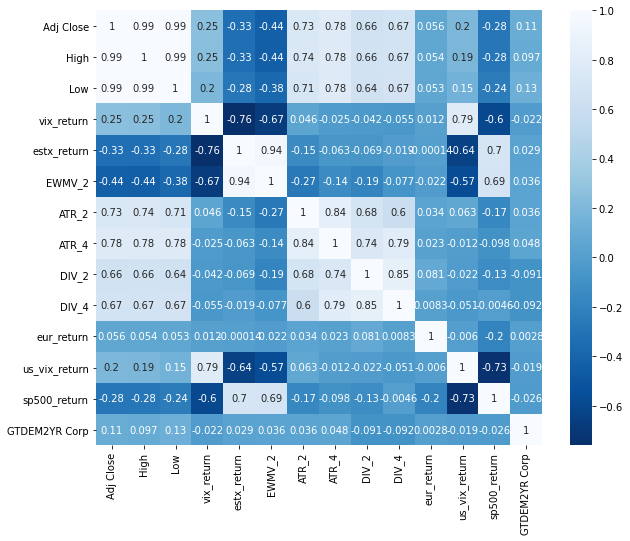

In [29]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(),annot=True,cmap='Blues_r')

In [28]:
scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X),index = X.index,columns=X.columns)
scaled_X

,Adj Close,High,Low,vix_return,estx_return,EWMV_2,ATR_2,ATR_4,DIV_2,DIV_4,eur_return,us_vix_return,sp500_return,GTDEM2YR Corp
2012-12-28,0.107182,-0.022195,-0.296285,0.000847,-0.029342,-0.041201,-0.464425,-1.027992,-0.320119,-0.210915,-0.043698,0.001227,-0.088407,0.662154
2013-01-04,-0.616156,-0.474749,-0.559849,-1.809890,1.114044,1.174900,-0.464425,-1.027992,-0.320119,-0.210915,1.508637,-3.066793,1.850544,0.837565
2013-01-11,-0.684654,-0.703627,-0.634071,-0.200613,0.085660,0.445891,-0.670702,-1.027992,-0.320119,-0.210915,-1.757664,-0.212463,0.076512,0.952556
2013-01-18,-0.642185,-0.684121,-0.621953,0.126500,-0.141069,0.010155,-1.273676,-1.027992,-0.320119,-0.210915,-0.743175,-0.429809,0.320580,1.048058
2013-01-25,-0.775071,-0.795959,-0.777971,-0.400873,0.439681,0.421032,-1.061620,-1.024560,-0.416049,-0.210915,-0.021133,0.210920,0.404976,1.190335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,0.592147,0.661837,0.748881,-0.710761,1.393472,1.644505,0.766146,0.628056,-0.174616,-0.015967,-1.837525,-0.878722,1.594680,4.447126
2022-11-04,0.320896,0.282108,0.392918,-0.527481,0.733442,1.241852,0.796155,0.588740,-0.164660,-0.246865,2.031168,-0.293723,-1.566012,4.827182
2022-11-11,0.029094,0.042827,0.155105,-0.621109,1.734100,2.053675,1.420663,1.303076,0.220086,-0.126214,-4.205982,-0.532197,2.399976,4.959714
2022-11-18,0.042794,0.006414,0.156620,0.031445,0.505269,1.162523,1.053274,1.102701,0.304994,-0.191574,-1.590060,0.163738,-0.389494,4.751171


In [30]:
# train and test
split_date_1 = dt.datetime(2020,11,20)
split_date_2 = dt.datetime(2020,11,27)
X_train, X_test = scaled_X.loc[:split_date_1,:], scaled_X.loc[split_date_2:,:]
Y_train, Y_test = Y[:split_date_1], Y[split_date_2:]
# train and validation
split_date_1 = dt.datetime(2018,12,14)
split_date_2 = dt.datetime(2019,12,21)
X_train_v, X_validation = X_train.loc[:split_date_1,:], X_train.loc[split_date_2:,:]
Y_train_v, Y_validation = Y_train.loc[:split_date_1], Y_train.loc[split_date_2:]

In [31]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [32]:
names = []
is_accuracy = []
os_accuracy = []
is_gmeanf1 = []
os_gmeanf1 = []

### Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier 

In [40]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = { 'min_samples_split': [2, 3, 4], 'max_depth': np.arange(3,14),
#                  'min_samples_leaf': [1,2,3,4]}
# model = DecisionTreeClassifier()
# optimized_DT = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_DT.fit(np.array(X_train_v), np.array(Y_train_v))
# model = optimized_DT.best_estimator_
# print('Best parameters：{0}'.format(optimized_DT.best_params_))
# print('Score:{0}'.format(optimized_DT.best_score_))

Best parameters：{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 3}
Score:0.5192307692307693


In [34]:
DT = DecisionTreeClassifier(max_depth=7,min_samples_leaf=1,min_samples_split=3).fit(X_train_v, Y_train_v)

In [35]:
y_pred_DT_is = DT.predict(X_train_v)
y_pred_DT_os = DT.predict(X_validation)
accuracy_DT_is = metrics.accuracy_score(Y_train_v, y_pred_DT_is)
accuracy_DT_os = metrics.accuracy_score(Y_validation, y_pred_DT_os)
print("DT accuarcy in sample:",accuracy_DT_is)
print("DT accuarcy out sample:",accuracy_DT_os)

DT accuarcy in sample: 0.9006410256410257
DT accuarcy out sample: 0.5833333333333334


In [36]:
g_mean_f1_DT_is = g_mean_f1(Y_train_v, y_pred_DT_is)
g_mean_f1_DT_os = g_mean_f1(Y_validation, y_pred_DT_os)
print("DT gmean f1 in sample:",g_mean_f1_DT_is)
print("DT gmean f1 out sample:",g_mean_f1_DT_os)

DT gmean f1 in sample: 0.9003981061478695
DT gmean f1 out sample: 0.5077524002897474


In [37]:
names.append('DT')
is_accuracy.append(accuracy_DT_is)
os_accuracy.append(accuracy_DT_os)
is_gmeanf1.append(g_mean_f1_DT_is)
os_gmeanf1.append(g_mean_f1_DT_os)

### Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = { 'n_estimators':[25,50,100,200],'min_samples_split': [2, 3, 4, 5], 'max_depth': np.arange(3,10),
#                  'min_samples_leaf': [1,2,3,4],'max_features':["auto", "sqrt", "log2"]}
# model = RandomForestClassifier()
# optimized_RF = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_RF.fit(np.array(X_train_v), np.array(Y_train_v))
# print('Best parameters：{0}'.format(optimized_RF.best_params_))
# print('Score:{0}'.format(optimized_RF.best_score_))

Best parameters：{'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 25}
Score:0.5721153846153846


In [39]:
RF= RandomForestClassifier(n_estimators=25,  max_features="log2", max_depth=7,
                           min_samples_leaf=2, min_samples_split=2).fit(X_train_v,Y_train_v)

In [40]:
y_pred_RF_is = RF.predict(X_train_v)
y_pred_RF_os = RF.predict(X_validation)
accuracy_RF_is = metrics.accuracy_score(Y_train_v, y_pred_RF_is)
accuracy_RF_os = metrics.accuracy_score(Y_validation, y_pred_RF_os)
print("RF accuarcy in sample:",accuracy_RF_is)
print("RF accuarcy out sample:",accuracy_RF_os)

RF accuarcy in sample: 0.9519230769230769
RF accuarcy out sample: 0.6666666666666666


In [41]:
g_mean_f1_RF_is = g_mean_f1(Y_train_v, y_pred_RF_is)
g_mean_f1_RF_os = g_mean_f1(Y_validation, y_pred_RF_os)
print("RF gmean f1 in sample:",g_mean_f1_RF_is)
print("RF gmean f1 out sample:",g_mean_f1_RF_os)

RF gmean f1 in sample: 0.951882026821616
RF gmean f1 out sample: 0.5091750772173156


In [42]:
names.append('RF')
is_accuracy.append(accuracy_RF_is)
os_accuracy.append(accuracy_RF_os)
is_gmeanf1.append(g_mean_f1_RF_is)
os_gmeanf1.append(g_mean_f1_RF_os)

### Extremely Randomized Trees

In [43]:
from sklearn.ensemble import ExtraTreesClassifier

In [170]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = {'n_estimators':[25,50,100,200],'min_samples_split': [2, 3, 4, 5], 'max_depth': np.arange(3,13),
#                  'min_samples_leaf': [1,2,3,4],'max_features':["auto", "sqrt", "log2"]}
# model = ExtraTreesClassifier()
# optimized_ETC = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_ETC.fit(np.array(X_train_v), np.array(Y_train_v))
# print('Best parameters：{0}'.format(optimized_ETC.best_params_))
# print('Score:{0}'.format(optimized_ETC.best_score_))

Best parameters：{'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 25}
Score:0.5673076923076923


In [44]:
ETC= ExtraTreesClassifier(n_estimators=25, 
                          max_depth=9,
                          max_features='auto',
                          min_samples_leaf=1,
                          min_samples_split=4).fit(X_train_v,Y_train_v.values.ravel())

In [45]:
y_pred_ETC_is = ETC.predict(X_train_v)
y_pred_ETC_os = ETC.predict(X_validation)
accuracy_ETC_is = metrics.accuracy_score(Y_train_v, y_pred_ETC_is)
accuracy_ETC_os = metrics.accuracy_score(Y_validation, y_pred_ETC_os)
print("ETC accuarcy in sample:",accuracy_ETC_is)
print("ETC accuarcy out sample:",accuracy_ETC_os)

ETC accuarcy in sample: 0.9711538461538461
ETC accuarcy out sample: 0.6458333333333334


In [46]:
g_mean_f1_ETC_is = g_mean_f1(Y_train_v, y_pred_ETC_is)
g_mean_f1_ETC_os = g_mean_f1(Y_validation, y_pred_ETC_os)
print("ETC gmean f1 in sample:",g_mean_f1_ETC_is)
print("ETC gmean f1 out sample:",g_mean_f1_ETC_os)

ETC gmean f1 in sample: 0.9711535454176186
ETC gmean f1 out sample: 0.5556985005098202


In [47]:
names.append('ETC')
is_accuracy.append(accuracy_ETC_is)
os_accuracy.append(accuracy_ETC_os)
is_gmeanf1.append(g_mean_f1_ETC_is)
os_gmeanf1.append(g_mean_f1_ETC_os)

### AdaBoost

In [48]:
from sklearn.ensemble import AdaBoostClassifier

In [41]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = {'n_estimators':[25,50,100,200],'learning_rate': np.linspace(0.1,1,10),'algorithm':['SAMME','SAMME.R'],
#             'base_estimator__min_samples_split': [2, 3, 4], 'base_estimator__max_depth': np.arange(3,5),
#                  'base_estimator__min_samples_leaf': [1,2,3,4]}
# base_estimator=DecisionTreeClassifier()
# model = AdaBoostClassifier(base_estimator=base_estimator)
# optimized_ADB = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_ADB.fit(np.array(X_train_v), np.array(Y_train_v))
# print('Best parameters：{0}'.format(optimized_ADB.best_params_))
# print('Score:{0}'.format(optimized_ADB.best_score_))

Best parameters：{'algorithm': 'SAMME.R', 'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 2, 'base_estimator__min_samples_split': 2, 'learning_rate': 1.0, 'n_estimators': 50}
Score:0.6153846153846154


In [49]:
base_estimator=DecisionTreeClassifier(max_depth=3,min_samples_leaf=2,min_samples_split=2)
ADB = AdaBoostClassifier(n_estimators=50, algorithm= 'SAMME.R',learning_rate=1.0,base_estimator=base_estimator).fit(X_train_v,Y_train_v)

In [50]:
y_pred_ADB_is = ADB.predict(X_train_v)
y_pred_ADB_os = ADB.predict(X_validation)
accuracy_ADB_is = metrics.accuracy_score(Y_train_v, y_pred_ADB_is)
accuracy_ADB_os = metrics.accuracy_score(Y_validation, y_pred_ADB_os)
print("ADB accuarcy in sample:",accuracy_ADB_is)
print("ADB accuarcy out sample:",accuracy_ADB_os)

ADB accuarcy in sample: 1.0
ADB accuarcy out sample: 0.5833333333333334


In [51]:
g_mean_f1_ADB_is = g_mean_f1(Y_train_v, y_pred_ADB_is)
g_mean_f1_ADB_os = g_mean_f1(Y_validation, y_pred_ADB_os)
print("ADB gmean f1 in sample:",g_mean_f1_ADB_is)
print("ADB gmean f1 out sample:",g_mean_f1_ADB_os)

ADB gmean f1 in sample: 1.0
ADB gmean f1 out sample: 0.48199920365414745


In [52]:
names.append('ADB')
is_accuracy.append(accuracy_ADB_is)
os_accuracy.append(accuracy_ADB_os)
is_gmeanf1.append(g_mean_f1_ADB_is)
os_gmeanf1.append(g_mean_f1_ADB_os)

### XGBoost

In [53]:
from xgboost import XGBClassifier
Y_xgbc_train_v = Y_train_v.apply(lambda x:np.where(x==-1,0,x))
Y_xgbc_validation = Y_validation.apply(lambda x:np.where(x==-1,0,x))

In [48]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = {'n_estimators': [25,50,100,200], 'learning_rate': [0.01, 0.1, 0.5, 1], 'max_depth': np.arange(3,10),
#                  'min_child_weight': [4, 5, 6, 7], 'gamma': [1, 3], 'reg_alpha': [0.1, 0.3,0.5],"reg_lambda": [0.3,0.5,0.7,0.9]}
# other_params = {'learning_rate': 0.1, 'n_estimators': 90, 'max_depth': 7, 'min_child_weight': 4,
#                     'subsample': 1, 'colsample_bytree': 0.9, 'gamma': 1, 'reg_alpha': 0.1, "reg_lambda": 0.9}
# model = XGBClassifier()
# optimized_XGBC = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_XGBC.fit(np.array(X_train_v), np.array(Y_xgbc_train_v))
# print('Best parameters：{0}'.format(optimized_XGBC.best_params_))
# print('Score:{0}'.format(optimized_XGBC.best_score_))

Best parameters：{'gamma': 1, 'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 25, 'reg_alpha': 0.5, 'reg_lambda': 0.9}
Score:0.5528846153846154


In [54]:
XGBC = XGBClassifier(learning_rate= 0.5,
                     n_estimators=25,
                     max_depth=5, 
                     min_child_weight=4, 
                     subsample= 1,
                     colsample_bytree= 0.9, 
                     gamma=1, 
                     reg_alpha= 0.5,
                     reg_lambda=0.9).fit(np.array(X_train_v), np.array(Y_xgbc_train_v))

In [55]:
y_pred_XGBC_is = XGBC.predict(X_train_v)
y_pred_XGBC_is = np.where(y_pred_XGBC_is==0,-1,y_pred_XGBC_is)
y_pred_XGBC_os = XGBC.predict(X_validation)
y_pred_XGBC_os = np.where(y_pred_XGBC_os==0,-1,y_pred_XGBC_os)
accuracy_XGBC_is = metrics.accuracy_score(Y_train_v, y_pred_XGBC_is)
accuracy_XGBC_os = metrics.accuracy_score(Y_validation, y_pred_XGBC_os)
print("XGBC accuarcy in sample:",accuracy_XGBC_is)
print("XGBC accuarcy out sample:",accuracy_XGBC_os)

XGBC accuarcy in sample: 0.9775641025641025
XGBC accuarcy out sample: 0.6458333333333334


In [56]:
g_mean_f1_XGBC_is = g_mean_f1(Y_train_v, y_pred_XGBC_is)
g_mean_f1_XGBC_os = g_mean_f1(Y_validation, y_pred_XGBC_os)
print("XGBC gmean f1 in sample:",g_mean_f1_XGBC_is)
print("XGBC gmean f1 out sample:",g_mean_f1_XGBC_os)

XGBC gmean f1 in sample: 0.9775638694362838
XGBC gmean f1 out sample: 0.5283178015262731


In [57]:
names.append('XGBC')
is_accuracy.append(accuracy_XGBC_is)
os_accuracy.append(accuracy_XGBC_os)
is_gmeanf1.append(g_mean_f1_XGBC_is)
os_gmeanf1.append(g_mean_f1_XGBC_os)

### Comparsion

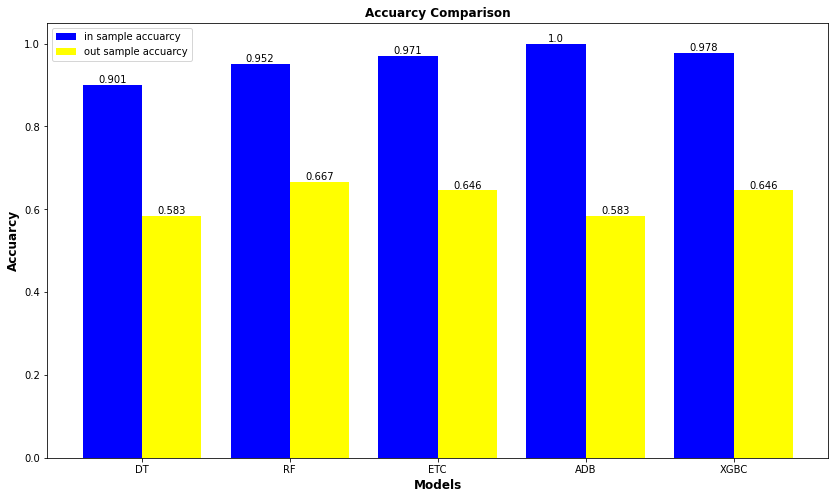

In [58]:
plt.figure(figsize = (14,8))

accuracy_df =pd.DataFrame({'name':names,'accuracy_is':is_accuracy,'accuracy_os':os_accuracy}).set_index('name')
x_axis = np.arange(len(accuracy_df))

barplot_is_accuarcy = plt.bar(x_axis-0.2, accuracy_df['accuracy_is'], 0.4, label='in sample accuarcy',color='blue')
barplot_os_accuarcy = plt.bar(x_axis+0.2, accuracy_df['accuracy_os'], 0.4, label='out sample accuarcy',color='yellow')

plt.bar_label(barplot_is_accuarcy, labels = np.round(accuracy_df['accuracy_is'],3))
plt.bar_label(barplot_os_accuarcy, labels = np.round(accuracy_df['accuracy_os'],3))

plt.xticks(x_axis, accuracy_df.index)
plt.xlabel("Models", fontsize = 12, fontweight = "bold") 
plt.ylabel("Accuarcy",fontsize = 12, fontweight = "bold")
plt.title("Accuarcy Comparison", fontsize = 12, fontweight = "bold")
plt.legend()
plt.show()

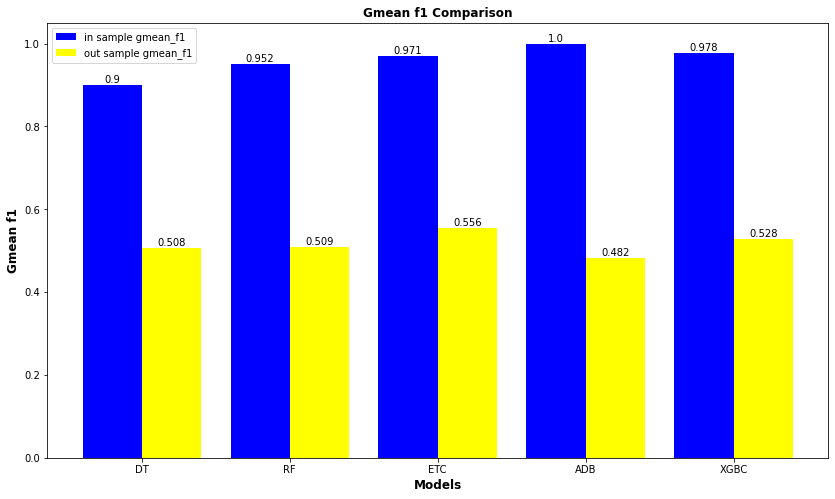

In [59]:
plt.figure(figsize = (14,8))

f1_df =pd.DataFrame({'name':names,'f1_is':is_gmeanf1,'f1_os':os_gmeanf1}).set_index('name')
x_axis = np.arange(len(f1_df))

barplot_is_f1 = plt.bar(x_axis-0.2, f1_df['f1_is'], 0.4, label='in sample gmean_f1',color='blue')
barplot_os_f1 = plt.bar(x_axis+0.2, f1_df['f1_os'], 0.4, label='out sample gmean_f1',color='yellow')

plt.bar_label(barplot_is_f1, labels = np.round(f1_df['f1_is'],3))
plt.bar_label(barplot_os_f1, labels = np.round(f1_df['f1_os'],3))

plt.xticks(x_axis, f1_df.index)
plt.xlabel("Models", fontsize = 12, fontweight = "bold") 
plt.ylabel("Gmean f1",fontsize = 12, fontweight = "bold")
plt.title("Gmean f1 Comparison", fontsize = 12, fontweight = "bold")
plt.legend()
plt.show()

### Select ETC model

In [79]:
ETC= ExtraTreesClassifier(n_estimators=25, 
                          max_depth=9,
                          max_features='auto',
                          min_samples_leaf=1,
                          min_samples_split=4).fit(X_train,Y_train.values.ravel())

In [80]:
y_pred_ETC_is = ETC.predict(X_train)
y_pred_ETC_os = ETC.predict(X_test)
accuracy_ETC_is = metrics.accuracy_score(Y_train, y_pred_ETC_is)
accuracy_ETC_os = metrics.accuracy_score(Y_test.dropna(), y_pred_ETC_os[:-1])
print("RF accuarcy in sample:",accuracy_ETC_is)
print("RF accuarcy out sample:",accuracy_ETC_os)

RF accuarcy in sample: 0.9007263922518159
RF accuarcy out sample: 0.5865384615384616


In [81]:
g_mean_f1_ETC_is = g_mean_f1(Y_train, y_pred_ETC_is)
g_mean_f1_ETC_os = g_mean_f1(Y_test.dropna(), y_pred_ETC_os[:-1])
print("RF gmean f1 in sample:",g_mean_f1_ETC_is)
print("RF gmean f1 out sample:",g_mean_f1_ETC_os)

RF gmean f1 in sample: 0.9004801461070087
RF gmean f1 out sample: 0.47256418926118954


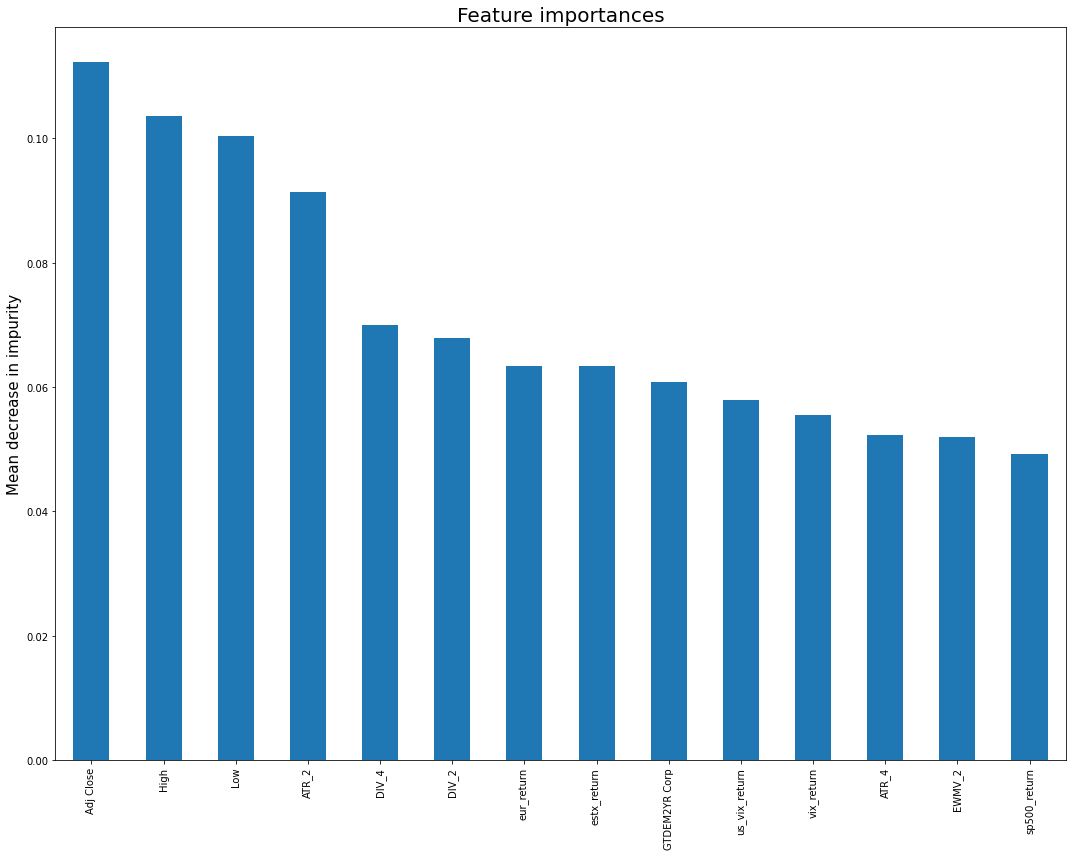

In [82]:
forest_importances = pd.Series(ETC.feature_importances_,index=X_train.columns)
forest_importances.sort_values(ascending=False,inplace=True)

fig,ax=plt.subplots(figsize=(15,12))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances",fontsize=20) 
ax.set_ylabel("Mean decrease in impurity",fontsize=15)
fig.tight_layout()

### Predict Result

In [83]:
result = pd.DataFrame({'actual':Y_test,'pred':ETC.predict(X_test)})
result

,actual,pred
2020-11-27,1.0,1.0
2020-12-04,1.0,-1.0
2020-12-11,-1.0,-1.0
2020-12-18,1.0,-1.0
2020-12-25,1.0,-1.0
...,...,...
2022-10-28,-1.0,-1.0
2022-11-04,-1.0,-1.0
2022-11-11,1.0,-1.0
2022-11-18,-1.0,-1.0


In [84]:
result.to_csv('v2tx_result.csv')

In [85]:
### class 1
len(result[result.actual == 1])/ len(result)

0.47619047619047616

In [86]:
### class 0
len(result[result.actual == -1])/ len(result)

0.5142857142857142